In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
from os import listdir
from os.path import isfile, join
import time
from datetime import timedelta
from matplotlib.ticker import MultipleLocator


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

from sklearn import model_selection, preprocessing, metrics, tree
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import IsolationForest, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer ,confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, ElasticNet, HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection


%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

seed_val = 42

In [88]:
# constants
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data/'
SUBMISSION_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions'
ENSEMBLE_PATH = ['/kaggle/dev/mercedes-benz-greener-manufacturing-data/ensemble/jsardinha/',
                 '/kaggle/dev/mercedes-benz-greener-manufacturing-data/ensemble/malhotra/']

In [89]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

In [90]:
# removing base features
train = train.iloc[:,0:2]
test = test.iloc[:,0:1]

In [91]:
# creating main data frames
models = {}
ignore_models = ['xgb5fold_1498527989']
file_count = 0
for ensemble_folder in ENSEMBLE_PATH:
    for file in listdir(ensemble_folder):
        if isfile(join(ensemble_folder, file)):
            file_count += 1
            filename = file.split("_")
            
            model_key = filename[1] + "_" + filename[2] 
            model_creator = filename[0]
            model_name = filename[1]
            model_timestamp = filename[2]
            model_LB = int(filename[3])/100000
            model_CV = int(filename[4])/100000
            model_type = filename[5]
            
            if not (model_key in ignore_models):
                models[model_key] = [model_creator, model_name, model_timestamp, model_LB, model_CV]

                read_csv = pd.read_csv(join(ensemble_folder, file))
                read_csv = read_csv.rename(columns={'y': 'y_' + model_key})
                if 'train' in model_type:
                    train = pd.merge(train, read_csv, on='ID', how='left')
                else:
                    test = pd.merge(test, read_csv, on='ID', how='left')
                
assert(file_count %2 ==0) # to ensure there are an even num. of files (tests and train) for each model

model_catalog = pd.DataFrame.from_dict(models, orient='index', dtype=None).reset_index()
model_catalog.columns = ['model_key', 'model_creator', 'model_name', 'model_timestamp', 'model_LB', 'model_CV']
del models

### Exploration

In [92]:
model_catalog

,model_key,model_creator,model_name,model_timestamp,model_LB,model_CV
0,xgb-5fold-with-feature-eng_1498579720,jsardinha,xgb-5fold-with-feature-eng,1498579720,0.52664,0.51887
1,stacked5fold_1498534487,malhot,stacked5fold,1498534487,0.54773,0.59343
2,dnn5fold_1498579219,malhot,dnn5fold,1498579219,0.52759,0.56370
3,xgb-5fold-with-feature-eng-inliers_1498592569,jsardinha,xgb-5fold-with-feature-eng-inliers,1498592569,0.52824,0.77624


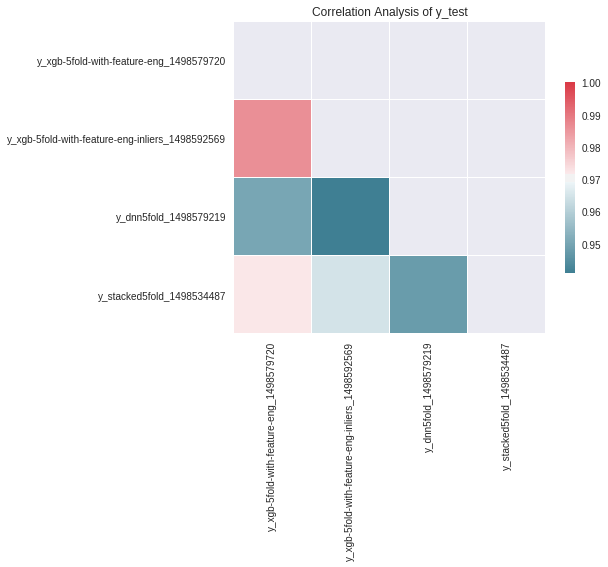

In [93]:
corr = test.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title('Correlation Analysis of y_test')
sns.heatmap(corr, mask=mask, cmap=cmap, square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

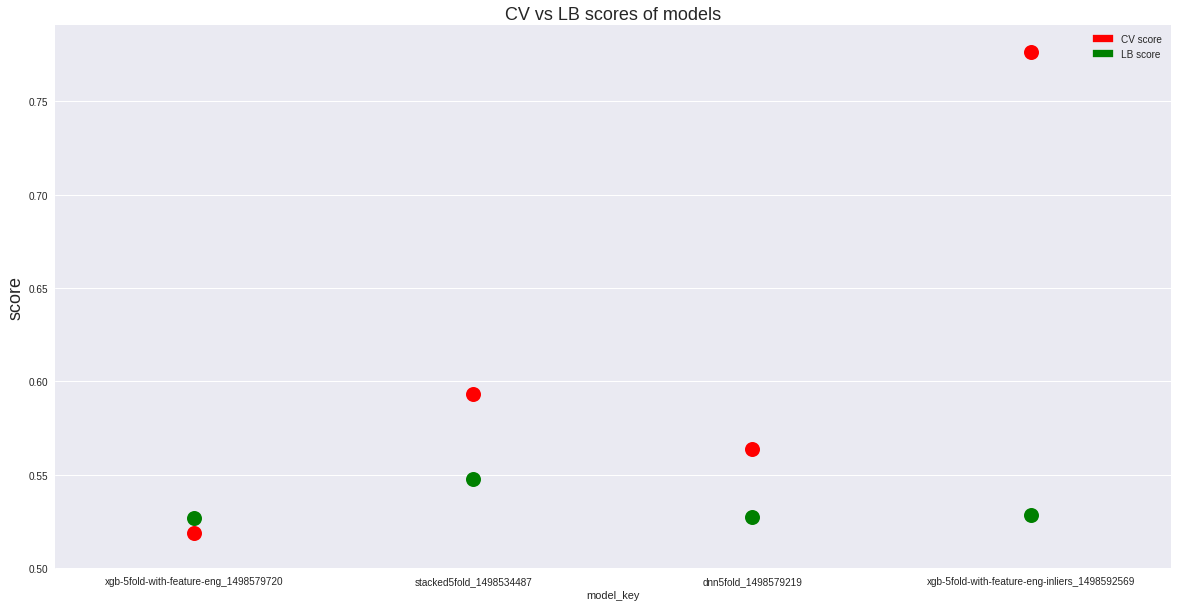

In [94]:
fig, ax = plt.subplots(figsize=(20,10))
sns.stripplot(model_catalog['model_key'], model_catalog['model_LB'], color="green", s=15)
sns.stripplot(model_catalog['model_key'], model_catalog['model_CV'], color="red", s=15)

red_patch = mpatches.Patch(color='red', label='CV score')
green_patch = mpatches.Patch(color='green', label='LB score')
plt.legend(handles=[red_patch, green_patch])

plt.title('CV vs LB scores of models', fontsize=18)
ax.set_ylabel('score', fontsize=18)

### Ensembling results

In [95]:
target_col = ['y']
ignore_cols = []
ignore_cols.append(target_col[0])
train_cols = [col for col in train.columns if col not in ignore_cols]

train_x = train[train_cols]
train_y = train[target_col]
test_x = test[train_cols]

print('--- encoding columns from train and test datasets ---')
for f in train_x.columns:
    if train_x[f].dtype=='object':
        print('encoding column:', f, '(original dtype:', train_x[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(train_x[f].values)| set(test_x[f].values))) 
        train_x[f] = lbl.transform(list(train_x[f].values))
        test_x[f] = lbl.transform(list(test_x[f].values))

--- encoding columns from train and test datasets ---


In [96]:
def xgb_r2(y_pred, dtrain):
    y_true = dtrain.get_label()
    r2_sklearn = r2_score(y_true, y_pred)
    r2_sklearn = r2_sklearn * -1.0
    return 'error', r2_sklearn

In [97]:
def oof_regression_predictor(train_x, train_y, test_x, n_folds, estimators, pred_cols, 
                             train_eval_metric, compare_eval_metric):
    
    start_time = time.time()
                                              
    # initializing blending data frames
    train_blend = train_x
    test_blend = test_x

    # Note: StratifiedKFold splits into roughly 66% train 33% test  
    skf = list(StratifiedKFold(train_y.values.ravel(), n_folds, random_state=seed_val))
    
    dataset_blend_train = np.zeros((train_x.shape[0], len(estimators)))
    dataset_blend_test = np.zeros((test_x.shape[0], len(estimators)))
    
    for j, estimator in enumerate(estimators):
        dataset_blend_test_j = np.zeros((test_x.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            trn_x = train_x.iloc[train, :] 
            trn_y = train_y.iloc[train].values.ravel()
            val_x = train_x.iloc[test, :] 
            val_y = train_y.iloc[test].values.ravel()

            # if xgb
            if ( 'dict' in str(type(estimator))):
                eval_set = [(trn_x, trn_y),(val_x, val_y)]
                model = XGBRegressor(**estimator).fit(trn_x, trn_y, eval_set=eval_set, verbose=False, 
                                                eval_metric=train_eval_metric)
            
            # else sklean
            else:          
                model = estimator.fit(trn_x, trn_y)
                
            pred_train = model.predict(val_x)
            dataset_blend_train[test, j] = pred_train
            print('fold:', i+1, '/', n_folds, '; estimator:',  j+1, '/', len(estimators), ' -> oof cv score:', 
                  compare_eval_metric(val_y, pred_train) )

            pred_test = model.predict(test_x)
            dataset_blend_test_j[:, i] = pred_test
    
        dataset_blend_test[:, j] = np.mean(dataset_blend_test_j, axis=1)
        
        
    print('--- comparing models ---')
    # comparing models
    for i in range(dataset_blend_train.shape[1]):
        print('model', i+1, 'cv score:', compare_eval_metric(train_y, dataset_blend_train[:,i]))
        
    for i, j in enumerate(estimators):
        train_blend[pred_cols[i]] = dataset_blend_train[:,i]
        test_blend[pred_cols[i]] = dataset_blend_test[:,i]
    
    end_time = time.time()
    print("Total Time usage: " + str(timedelta(seconds=int(round(end_time - start_time)))))
    return train_blend, test_blend, model

In [98]:
# Predictors
estimators = [
    {
        'objective': "reg:linear",
        'max_depth': 5,
        'n_estimators': 100,
        'learning_rate': 0.05,
        'nthread': 12,
        'seed': seed_val,
        'subsample': 0.7,
         'colsample_bytree': 0.7,
        'min_child_weight': 1,
        'gamma':10,
        'silent': True
    }
]

pred_cols = ['pred1_xgb_y_pred']

train_blend, test_blend, model = oof_regression_predictor(train_x, 
                                                     train_y, 
                                                     test_x, 
                                                     n_folds = 5, 
                                                     estimators=estimators, 
                                                     pred_cols = pred_cols,  
                                                     train_eval_metric=xgb_r2,
                                                     compare_eval_metric=r2_score)

/kaggle/dev/jovan/mercedes-benz-greener-manufacturing/venv-mercedes/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


fold: 1 / 5 ; estimator: 1 / 1  -> oof cv score: 0.608303677251
fold: 2 / 5 ; estimator: 1 / 1  -> oof cv score: 0.825888560027
fold: 3 / 5 ; estimator: 1 / 1  -> oof cv score: 0.868161158631
fold: 4 / 5 ; estimator: 1 / 1  -> oof cv score: 0.900731262143
fold: 5 / 5 ; estimator: 1 / 1  -> oof cv score: 0.85042103719
--- comparing models ---
model 1 cv score: 0.665784718302
Total Time usage: 0:00:01


In [99]:
post_analysis = train_x.copy()
post_analysis['y_pred'] = train_x[pred_cols[0]]
post_analysis['y_true'] = train_y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

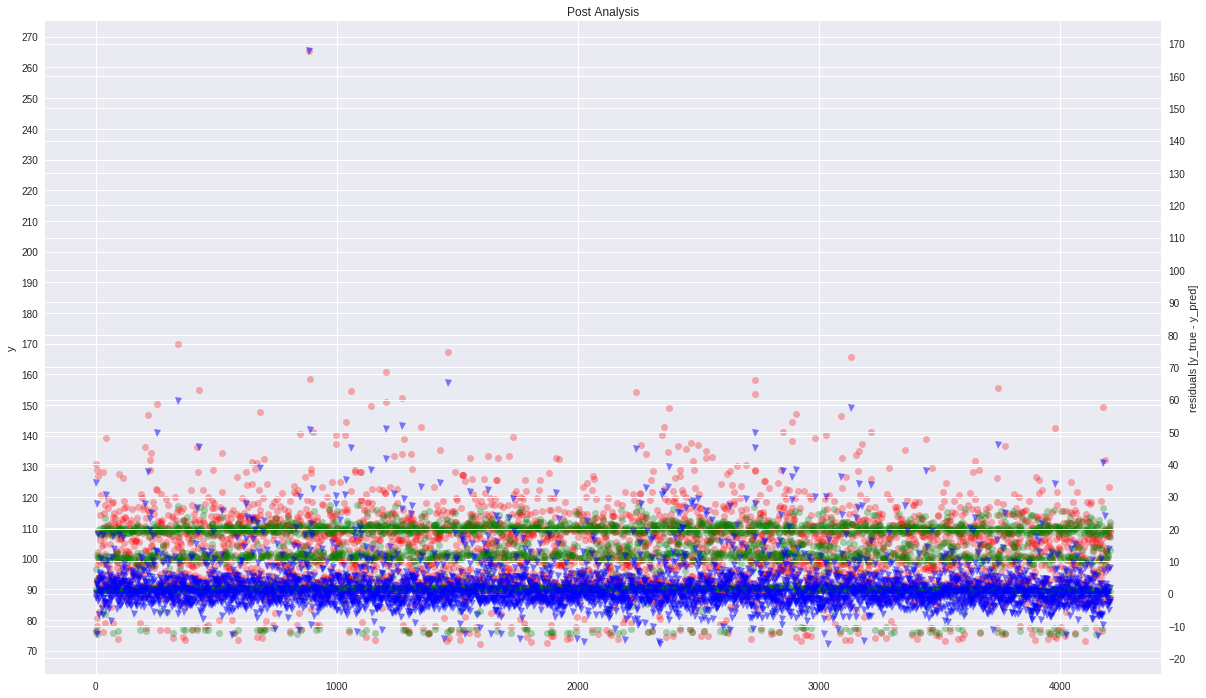

In [100]:
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

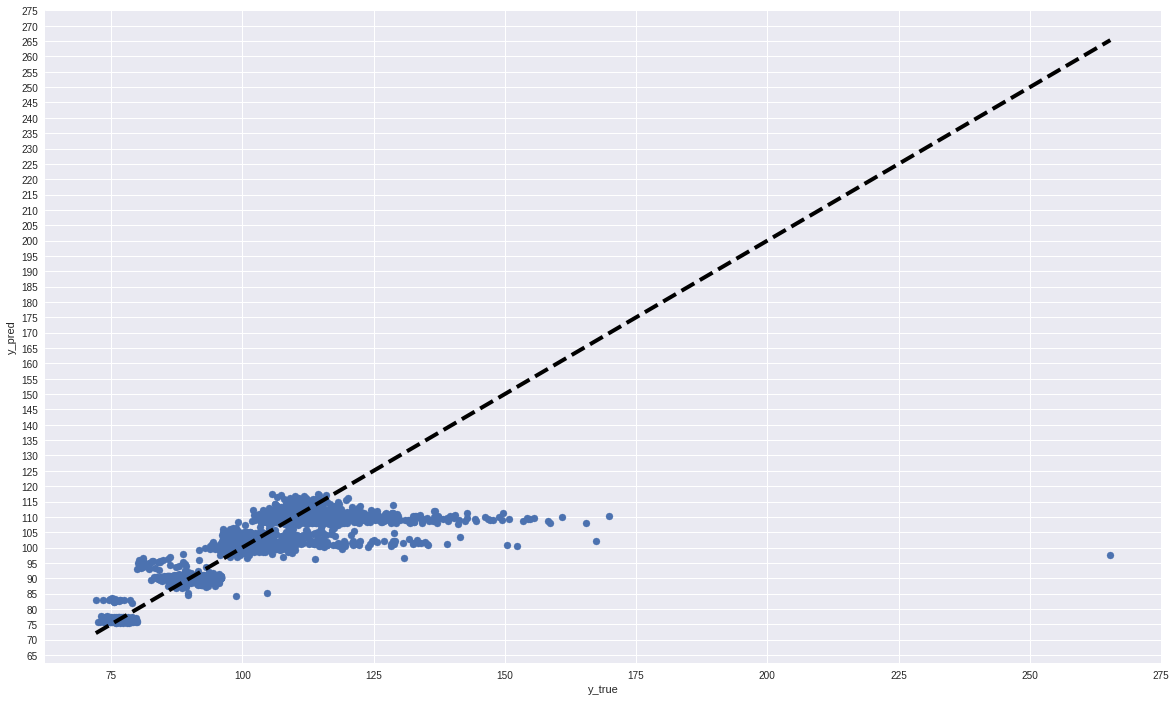

In [101]:
majorLocator = MultipleLocator(5)
fig, ax = plt.subplots(figsize=(20,12))
plt.scatter( post_analysis['y_true'],  post_analysis['y_pred'])
plt.plot([ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 
        [ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 'k--', lw=4)
ax.yaxis.set_major_locator(majorLocator)
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')
plt.show()

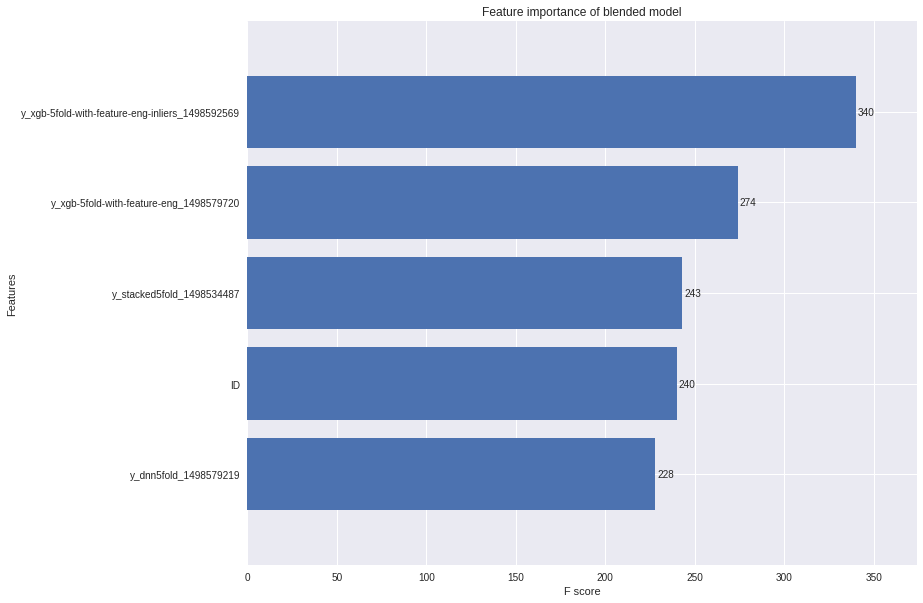

In [102]:
fig, ax = plt.subplots(figsize=(12,10))

xgb.plot_importance(model, height=0.8, ax=ax, title='Feature importance of blended model')

### Submission

In [17]:
def generate_submission_file(output_path, test_x, team_name):
    test_x['y'] = test_x[pred_cols[0]]
    test_x = test_x[['ID', 'y']]
    
    # Preparing to output
    timestamp = str(int(time.time()))
    filename = output_path + '/submission-' + team_name + '-' + timestamp + ".csv"
    test_x.to_csv(filename, index=False)
    print('output filename:', filename)

In [18]:
team_name = 'deep6ix'
#generate_submission_file(SUBMISSION_PATH, test_x, team_name)

output filename: /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-deep6ix-1498659515.csv
